# Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
apple = pd.read_csv('histories/apple.csv')
amazon = pd.read_csv('histories/amazon.csv')
microsoft = pd.read_csv('histories/microsoft.csv')
google = pd.read_csv('histories/google.csv')
dfs = [apple, amazon, microsoft, google]
titles = ['Apple', 'Amazon', 'Microsoft', 'Google']

In [3]:
amazon.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [4]:
# Fix datatypes 
for df in dfs:
    df['Date'] = pd.to_datetime(df['Date'])

In [5]:
def create_timestamp(year, month=1, day=1):
    return pd.Timestamp('{}-{:02d}-{:02d} 00:00:00'.format(year, month, day))

In [6]:
def tvt_split(df, splits=[.8, .9]):
    df_cut = df[df.Date >= create_timestamp(2005)]
    train = df_cut[:int(splits[0] * len(df_cut))]
    val = df_cut[int(splits[0]* len(df_cut)):int(splits[1] * len(df_cut))]
    test = df_cut[int(splits[1] * len(df_cut)):]

    return train, val, test

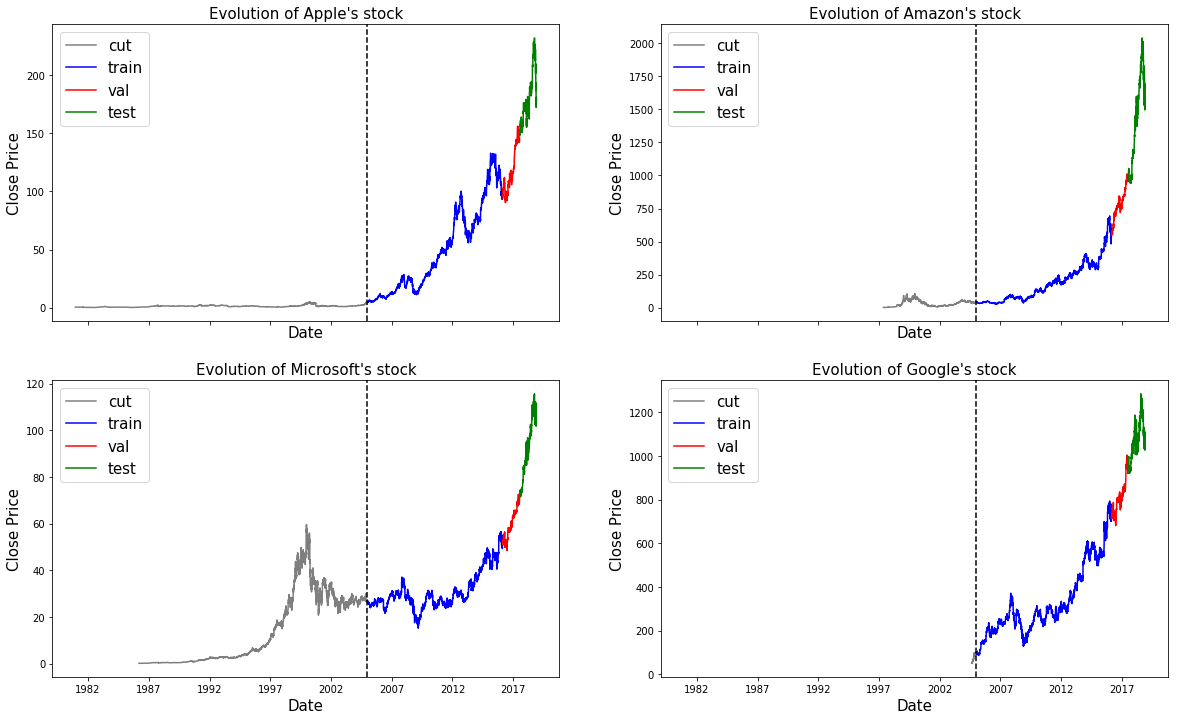

In [7]:
fig, axes = plt.subplots(2,2, figsize=(20,12), sharex=True)

for i, ax in enumerate(axes.flatten()):
    train, val, test = tvt_split(dfs[i])
    df_cut = dfs[i][dfs[i].Date < create_timestamp(2005)]
    ax.plot(df_cut.Date, df_cut.Close, '-k', alpha=.5, label='cut')
    ax.plot(train.Date, train.Close, '-b', label='train')
    ax.plot(val.Date, val.Close, '-r', label='val')
    ax.plot(test.Date, test.Close, '-g', label='test')
    ax.axvline(x=create_timestamp(2005), color='k', linestyle='--')
    ax.set_ylabel("Close Price", fontsize=15)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_title("Evolution of {}'s stock".format(titles[i]), fontsize=15)
    ax.legend(fontsize=15)
    
plt.savefig('data_cut.png')

We decided to consider the same time period for each stock, choosing 2005 to be the cut off point and dividing the rest of the data into an 80/10/10 train/val/test split. 

In [8]:
for i, df in enumerate(dfs):
    df_cleaned = df[df.Date >= create_timestamp(2005)]
    df_cleaned.to_csv('{}_cleaned.csv'.format(titles[i]))

# Evaluation of Agents

In [9]:
from utils import gen_states, evaluate_agent
from Baseline_agent.baseline_agent import BaselineAgent
from linearAQ_agent.linearAQ import LinearAQ
from NNQ_agent.NNQ import NNQ

In [10]:
# Initializations
window_size = 5  # time window size
history_size = 3  # number of previous days to consider
train, val, test = gen_states('histories/Apple_cleaned.csv', window_size, history_size)  # data
actions = ['buy', 'wait']  # action space
epsilon = .05  # amount of randomness
discount = 1  # discount factor
alpha = .1
num_layers = 2  # number of layers in neural net
num_units = 100  # number of nodes per layer in neural net
c = -1 # constant for baseline model

base_agent = BaselineAgent(c)
linear_agent = LinearAQ('train', actions, train, epsilon, discount, alpha)
nn_agent = NNQ('train', actions, train, epsilon, discount, num_layers, num_units)

base_profit, base_noaction, base_timebought = evaluate_agent(base_agent, val, verbose=False)
linear_profits = []
nn_profits = []
for i in range(1,100):
    if i%5 == 0:
        print('Progress: {}%'.format(i))
    # train agents
    linear_agent.learn()
    nn_agent.learn()
    
    # test agents
    linear_profit, linear_noaction, linear_timebought = evaluate_agent(linear_agent, val, verbose=False)
    nn_profit, nn_noaction, nn_timebought = evaluate_agent(nn_agent, val, verbose=False)
    
    # store data
    linear_profits.append(linear_profit)
    nn_profits.append(nn_profit)
    
    # reset agents
    linear_agent.reset()
    nn_agent.reset()
    


Progress: 5%
Progress: 10%
Progress: 15%
Progress: 20%
Progress: 25%
Progress: 30%
Progress: 35%
Progress: 40%
Progress: 45%
Progress: 50%
Progress: 55%
Progress: 60%
Progress: 65%
Progress: 70%
Progress: 75%
Progress: 80%
Progress: 85%
Progress: 90%
Progress: 95%


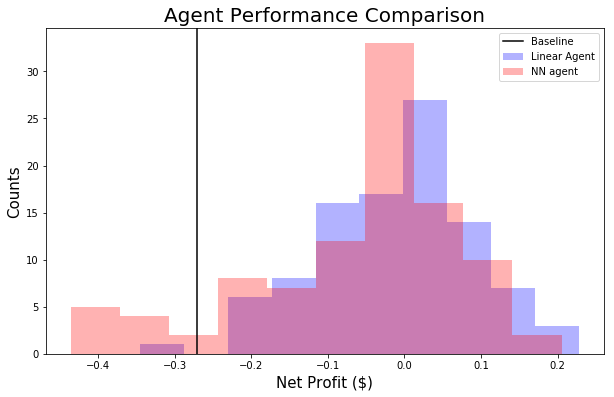

In [15]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(linear_profits, color='b', alpha=.3, label='Linear Agent')
ax.hist(nn_profits, color='r', alpha=.3, label='NN agent')
ax.axvline(x=base_profit, color='k', label = 'Baseline')
ax.set_xlabel('Net Profit ($)', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title('Agent Performance Comparison', fontsize=20)
ax.legend(fontsize=10)
plt.savefig('images/agent_comparison.png')